### Курсовой проект "Python для Data Science"

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2
import warnings
import random

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100


%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14.0

In [3]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Загрузка данных

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_test.shape

((10000, 20), (5000, 19))

### Oписание датасета:
- Id - номер квартиры в датасете
- DistrictId - Принадлежность к разным районам, относится к катигориальным признакам
- Rooms - Количество комнат
- Square - Площадь квартиры
- LifeSquare - Жилая площадь
- KitchenSquare - Площадь кухни
- Floor - Этаж квартиры
- HouseFloor - Этажность дома
- HouseYear - Год постройки дома
- Ecology_1 - Состояние экологии.
- Ecology_2, Ecology_3 - Коэффициенты экологические
- Social_1, Social_2, Social_3 - Социальные коэффициенты
- Healthcare_1, Healthcare_2 - Показатели защиты здоровья
- Shops_1, Shops_2 - Показатели наличия магазинов
- Price - Цена квартиры

### Анализ данных

In [5]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

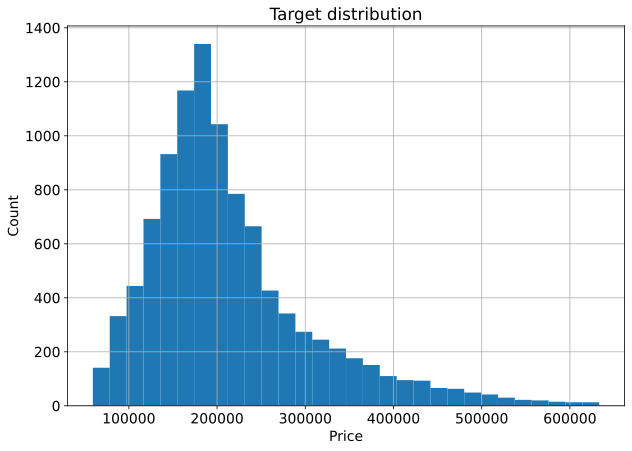

In [7]:
# Распределение количества квартир к их стоимости
plt.figure(figsize = (10, 7))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

<Figure size 432x216 with 0 Axes>

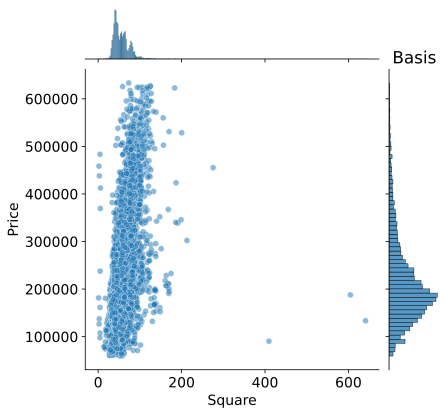

In [8]:
# Графическая зависимость площади от цены
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.Square, df_train.Price, alpha = 0.5)
plt.xlabel('Square')
plt.ylabel('Price')
plt.title('Basis')
plt.show()

### Приведение типов данных

In [9]:
df_train['Rooms'] = df_train['Rooms'].astype('int64')
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int64')

df_test['Rooms'] = df_test['Rooms'].astype('int64')
df_test['HouseFloor'] = df_test['HouseFloor'].astype('int64')

In [10]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [11]:
# Смотрим выбросы в Rooms на тренировочном датасете
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [12]:
# Смотрим выбросы в Rooms на тестовом датасете
df_test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

In [13]:
# Делим данные на тренировочные и валидационные
train, valid = train_test_split(df_train, test_size=0.3, random_state=50)

In [14]:
df_train['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
47        1
38        1
36        1
29        1
44        1
31        1
117       1
45        1
26        1
Name: HouseFloor, dtype: int64

In [15]:
# Находим среднее по значению HouseYear
mean_year = np.round(train.loc[train['HouseYear'] <= 2021, 'HouseYear'].mean())
mean_year

1985.0

<AxesSubplot:xlabel='Square'>

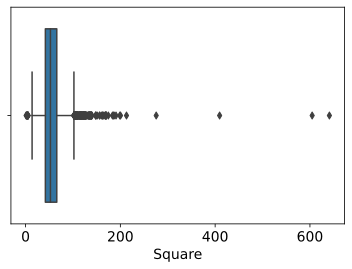

In [16]:
# Анализируем выбросы по площади с помощью ящика с усами
sns.boxplot(df_train['Square'], orient='v')

### Обрабатываем данные

In [17]:
# Помечаем выбросы и пропуски
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [18]:
# Анализ выбросов по значению Floor
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [19]:
# Помечаем выбросы
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor_outlier'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [20]:
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   24,   25,   26,   33,   34,   37,   39,
            ...
            9931, 9938, 9940, 9950, 9953, 9960, 9968, 9970, 9975, 9996],
           dtype='int64', length=1825)

In [21]:
# Обрабатываем значение HouseFloor
def update_floor(df, floor_outliers):
    # Обрабатываем вариант, когда этаж = 0
    df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
    # Обрабатываем вариант, когда значение этажа больше значения этажность дома
    df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [22]:
# Больше 6 комнат вряд ли возможно, так же как и 0. Обработаем выбросы функцией 
def update_rooms(df):
    df.loc[df['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1


In [23]:
# Помечаем выбросы и пропуски
df_train['Square_outlier'] = 0
df_train.loc[df_train['Square'] > 250, 'Square_outlier'] = 1
df_train['KitchenSquare_outlier'] = 0
df_train.loc[(df_train['KitchenSquare'] < 3) | (df_train['KitchenSquare'] > 22), 'KitchenSquare_outlier'] = 1
df_train.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,Square_outlier,KitchenSquare_outlier
9990,10635,21,1,18.983962,11.419796,2.0,1,5,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.221700,0,1,0,1
9991,11173,6,2,62.648779,NaN,0.0,6,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872,0,1,0,1
9992,11753,37,2,50.902724,27.159548,6.0,4,9,1972,0.127812,B,B,28,7287,5,320.0,1,3,B,196641.468817,0,1,0,0
9993,9289,1,3,84.486078,88.931509,0.0,4,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.558631,0,1,0,1
9994,4356,9,1,43.303458,21.519087,8.0,12,14,1992,0.161532,B,B,25,5648,1,30.0,2,4,B,136744.340827,0,1,0,0
9995,1260,61,2,49.090728,33.272626,6.0,3,12,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,1,0,0
9996,16265,27,2,64.307684,37.038420,9.0,13,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,1,0,0
9997,2795,178,1,29.648057,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,1,0,0
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855,0,1,0,0
9999,7202,94,1,35.815476,22.301367,6.0,9,9,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486,0,1,0,0


In [24]:
# Обрабатываем данные Square
# Обрабатываем данные KitchenSquare
def update_square(df):
    df.loc[df['Square'] > 250, 'Square'] = train['Square'].median()
    df.loc[(df['KitchenSquare'] < 3) | (df['KitchenSquare'] > 22), 'KitchenSquare'] = train['KitchenSquare'].median()

In [25]:
# Помечаем выбросы и пропуски
df_train['LifeSquare_outlier'] = 0
df_train.loc[df_train['Square'] > 250, 'Square_outlier'] = 1
df_train.loc[(df_train['LifeSquare'] < 5) | (df_train['LifeSquare'].isnull()), 'LifeSquare_outlier'] = 1
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier
0,11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,1,0,0,1
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,1,0,0,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,1,0,0,0
3,2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,1
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,1,0,0,0


In [26]:
# Обрабатываем данные LifeSquare
def update_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square']*0.8
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']

In [27]:
# Помню, что вы говорили не обрабатывать адресно, но тут всего 2 значения) не удержался
# ограничил нижнее значение, домов переживших пожар 1812 года почти не осталось соответственно значения будут выбросами
def update_year(df, mean_year):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year
    df.loc[df['HouseYear'] < 1800, 'HouseYear'] = mean_year

In [28]:
# Обрабатываем признаки
def update_feature(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)

In [29]:
# Компилируем функции для обработки данных 
def prepare_df(df, mean_year=mean_year, floor_outliers=floor_outliers):
    update_square(df)
    update_life_square(df)
    update_year(df, mean_year)
    update_rooms(df)
    update_feature(df)
    update_floor(df, floor_outliers)

In [30]:
# Применяем к датасетам
prepare_df(train)
prepare_df(valid)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5189,4842,5,2,44.408977,26.716904,6.0,2,5,1966,0.150818,1,1,16,3433,4,2643.0,4,5,1,188350.645702
7969,3791,45,2,66.243833,52.995066,6.0,16,0,1977,0.195781,1,1,23,5212,6,NaN,3,2,1,371285.581161
9039,1270,30,2,66.486158,53.188926,6.0,16,17,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,175503.767602
5208,4050,193,2,46.034264,33.918107,5.0,4,5,1966,0.319809,1,1,25,4756,16,2857.0,5,8,1,181025.397125
506,12624,78,3,61.750846,48.029672,6.0,5,9,1972,0.092291,1,1,21,4346,2,165.0,1,2,1,277001.792898


### Модель Случайный Лес

In [31]:
# Задаем признаки для модели
feats = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'HouseFloor', 'HouseYear', 'Ecology_1',
         'Ecology_3', 'Helthcare_2', 'Social_3', 'Shops_1', 'Shops_2']

In [32]:
def evaluate_model(model, train, valid, metric, feats, target, max_depth):
    dtr = model(max_depth=max_depth, random_state=50, criterion='mse')
    dtr.fit(train.loc[:, feats], train[target])
    y_pred_train = dtr.predict(train.loc[:, feats])
    y_pred_valid = dtr.predict(valid.loc[:, feats])
    metric_train = metric(train['Price'], y_pred_train)
    metric_valid = metric(valid['Price'], y_pred_valid)
    return metric_train, metric_valid

In [33]:
def check_param(min_value, max_value, model, train=train, valid=valid, metric=r2, feats=feats, target='Price'):
    max_depth_arr = []
    metric_train_arr = []
    metric_valid_arr = []

    for i in range(min_value, max_value+1):
        res = evaluate_model(model, train, valid, metric, feats, target, max_depth=i)
        metric_train_arr.append(res[0])
        metric_valid_arr.append(res[1])
        max_depth_arr.append(i)
    return max_depth_arr, metric_train_arr, metric_valid_arr

In [34]:
# Подбираем параметры для модели
max_depth_arr, metric_train_arr, metric_valid_arr = check_param(10, 20, model=RFR)

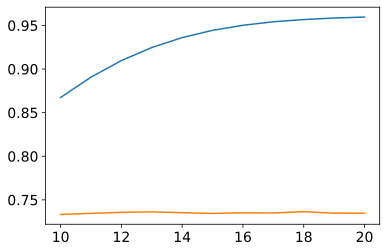

In [35]:
# Создаем график для определения глубины дерева
plt.plot(max_depth_arr, metric_train_arr)
plt.plot(max_depth_arr, metric_valid_arr)

In [36]:
# Задаём оптимальные параметры для модели
model = RFR(n_estimators=170, max_depth=16, random_state=50, criterion='mse')

In [37]:
# Обучаем модель
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(criterion='mse', max_depth=16, n_estimators=170,
                      random_state=50)

In [38]:
y_pred_train = model.predict(train.loc[:, feats])

In [39]:
# Определяем коэффициент детерминации для Train набора данных
r2(train['Price'], y_pred_train)

0.9511318695557184

In [40]:
y_pred_valid = model.predict(valid.loc[:, feats])

In [41]:
# Определяем коэффициент детерминации для Valid набора данных
r2(valid['Price'], y_pred_valid)

0.7371802490624102

In [42]:
prepare_df(df_test)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1
1,5925,62,1,42.493907,42.493907,10.0,7,17,2017,0.072158,1,1,2,629,1,NaN,0,0,0
2,960,27,2,59.463678,47.570943,9.0,19,19,1977,0.211401,1,1,9,1892,0,NaN,0,1,1
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,1,1,2,475,0,NaN,0,0,1
4,746,74,1,53.837056,43.069644,6.0,8,17,1977,0.309479,1,1,35,7715,4,990.0,0,6,1


In [43]:
df_test['Price'] = model.predict(df_test.loc[:, feats])

In [44]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,161617.215410
1,5925,62,1,42.493907,42.493907,10.0,7,17,2017,0.072158,1,1,2,629,1,NaN,0,0,0,121848.204690
2,960,27,2,59.463678,47.570943,9.0,19,19,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,139151.133246
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,1,1,2,475,0,NaN,0,0,1,103888.577534
4,746,74,1,53.837056,43.069644,6.0,8,17,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,212692.684993


In [45]:
# Выгружаем результат в файл
df_test.loc[:, ['Id', 'Price']].to_csv('Isavelyev_predictions_v1a.csv', index=False)